In [2]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

# Testing methanol 

In [3]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = (
    r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\a_ch3oh.dat"  # file downloaded from LAMDA database
)


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 3 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
    treat_line_overlap=True,
)

N = 1e17 / constants.centi**2  # CO column density in m-2
Tkin = 150  # kinetic temperature in [K]


# collider densities in m-3 (phytonradex takes the densities in m-3):
LTE_collider_densities_h2only = {"H2": 1e7 / constants.centi**3}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\rate_equations.py:275: RuntimeWarning: invalid value encountered in divide
  return np.where(tau_tot==0,0,(1-beta)*tau_line/tau_tot*A21)
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\rate_equations.py:275: RuntimeWarning: invalid value encountered in divide
  return np.where(tau_tot==0,0,(1-beta)*tau_line/tau_tot*A21)


5-4: tau_nu0 = -0.0504
7-6: tau_nu0 = -0.0549
10-9: tau_nu0 = -0.0333
13-12: tau_nu0 = -0.0378
31-29: tau_nu0 = -0.145
30-28: tau_nu0 = -0.163
18-17: tau_nu0 = -0.0361
24-23: tau_nu0 = -0.0338
74-73: tau_nu0 = -1.88
33-32: tau_nu0 = -0.0298
64-62: tau_nu0 = -2.72
42-39: tau_nu0 = -0.0286
135-134: tau_nu0 = -5.22e-06
53-52: tau_nu0 = -0.0258
133-131: tau_nu0 = -0.786
134-132: tau_nu0 = -0.783
27-23: tau_nu0 = -4.99
64-61: tau_nu0 = -0.0254
75-74: tau_nu0 = -0.0183
26-22: tau_nu0 = -0.0632
25-21: tau_nu0 = -0.0618
87-86: tau_nu0 = -1.68
88-87: tau_nu0 = -0.0149
101-100: tau_nu0 = -0.00914
75-72: tau_nu0 = -2.63
116-113: tau_nu0 = -0.00953
150-147: tau_nu0 = -0.466
151-146: tau_nu0 = -0.446
34-32: tau_nu0 = -5.01
135-128: tau_nu0 = -0.00855
100-97: tau_nu0 = -1.7
88-85: tau_nu0 = -2.44
113-112: tau_nu0 = -1.1
47-39: tau_nu0 = -5.15
101-96: tau_nu0 = -1.97
128-127: tau_nu0 = -0.344
56-52: tau_nu0 = -4.67
116-111: tau_nu0 = -1.63
151-141: tau_nu0 = -0.269
134-127: tau_nu0 = -0.0762
67-61: t

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [4]:
# store the data
data = LAMDA_file.read(datafilepath, read_frequencies=False, read_quantum_numbers=True)

# Initialize g_weigth
levels = data["levels"]
rad_transitions = data["radiative transitions"]
coll_transitions = data["collisional transitions"]
quantum_numbers = data["quantum numbers"]


In [5]:
# selected_quantum_numbers_with_indices = [(i, qn) for i, qn in enumerate(quantum_numbers) if qn.split("_")[1] == "1"]
# indices = [i for i, qn in selected_quantum_numbers_with_indices]
# print(indices)

# my class

In [7]:
class MyClass:
    def __init__(self, cloud_name, data_of_molecule, column_density_species, width_v):
        """
        Initialize the class with the cloud object, the data of the molecule, the column density of the species, the width of the line

        Parameters
        ----------
        cloud_name : pythonradex.Cloud
            The cloud object.
        data_of_molecule : dict
            The data of the molecule. It should contain the levels, radiative transitions, quantum numbers, and the molecule name. This is the output of the LAMDA_file.read_file() function.
        column_density_species : float
            The column density of the species in m^2.
        width_v : float
            The width of the line in m/s
        Tkin : float
            The kinetic temperature in [K].
        """
        self.cloud_name = cloud_name
        self.data_of_molecule = data_of_molecule
        self.column_density_species = column_density_species
        self.width_v = width_v
        self.extract_and_calculate(debug=False)  # this allows optical_depth to use the extracted values from the extract_and_calculate method

    def get_transition_populations(self, names_transitions, debug=False):
        """
        Relates all the transitions in names_transitions with their corresponding population densities.

        Parameters
        ----------
        names_transitions: (list of str):
            List of transitions in the format ['79-78', '14-13', ...], where each element is a string with the format "upper_level-lower_level".

        Returns
        -------
            tuple: Two arrays, one for upper and one for lower populations density.
        """
        upper_populations = []
        lower_populations = []
        self.upper_level_transition_index = []
        self.lower_level_transition_index = []
        if debug:
            print("num_transitions:", len(names_transitions))

        for transition in names_transitions:
            upper_level, lower_level = map(int, transition.split("-"))  # split the string and convert to integers
            upper_pop = self.cloud_name.level_pop[upper_level]
            lower_pop = self.cloud_name.level_pop[lower_level]
            upper_populations.append(upper_pop)
            lower_populations.append(lower_pop)
            self.upper_level_transition_index.append(upper_level)
            self.lower_level_transition_index.append(lower_level)

        nu = np.array(upper_populations)
        nl = np.array(lower_populations)
        # compute upper level population density, given by: fractional population density x total column density
        Nu = nu * self.column_density_species
        Nl = nl * self.column_density_species
        return Nu, Nl

    def extract_and_calculate(self, debug=False):
        """
        Extract values from the cloud object and the data file, and calculate gamma factor

        Parameters
        ----------
        debug : boolean, optional
            If True, print debugging information. Default is False.

        Returns
        --------
        Tex: np.array
            The excitation temperature of the molecule.
        tau: np.array
            The optical depth of the transitions.
        Aul : np.array
            The Einstein coefficient for spontaneous emission [s^-1].
        Bul : np.array
            The Einstein coefficient for stimulated emission in [sr m2 Hz / Jy].
        nu0_array : np.array
            The rest frequency of the transition in Hz.
        Eu : np.array
            The energy of the upper level in [K].
        gu : np.array
            The statistical weight of the upper level.
        gamma: np.array
            Gamma factors, which is calculated using: gamma = (8 * np.pi * k * nu0**2) / (h * c**3 * Aul)
        Nu: np.array
            Upper level population density in [m-2].
        Nl: np.array
            Lower level population density in [m-2].
        FWHM_each_transition: np.array
            Frequency width of each transition in [Hz].
        """
        # Extract values
        self.Tex = self.cloud_name.Tex
        self.Aul = self.cloud_name.emitting_molecule.A21
        self.Bul = self.cloud_name.emitting_molecule.B21
        self.nu0_array = self.cloud_name.emitting_molecule.nu0
        self.tau = self.cloud_name.tau_nu(self.nu0_array)

        # levels = self.data_of_molecule["levels"]
        rad_transitions = self.data_of_molecule["radiative transitions"]

        # Extract upper energy levels in [J] and convert to Kelvin
        self.Eu = np.array([transition.up.E for transition in rad_transitions]) / constants.k

        # Get the statistical weight of the upper and lower levels
        self.gu = np.array([transition.up.g for transition in rad_transitions])
        self.glow = np.array([transition.low.g for transition in rad_transitions])

        # Get names of transitions
        names_transitions = np.array([tran.name for tran in rad_transitions])

        # Compute upper and lower level population densities
        self.Nu, self.Nl = self.get_transition_populations(names_transitions, debug=debug)

        # Convert velocity width to frequency width
        self.FWHM_each_transition = self.nu0_array * (self.width_v / constants.c)

        # Calculate gamma factor
        self.gamma = (8 * np.pi * constants.k * self.nu0_array**2) / (constants.h * constants.c**3 * self.Aul)

        if debug:
            # Debugging print statements
            print("Size of nu0_array:", len(self.nu0_array))
            print("Size of Eu:", len(self.Eu))
            print("E upper levels:", self.Eu)
            print("Size of gu:", len(self.gu))
            print("size exitation temperature Tex:", len(self.Tex))
            print(" gu:", self.gu)
            print("Size of glow:", len(self.glow))
            print(" glow:", self.glow)
            print("size Aul:", len(self.Aul))
            print("size FWHM_each_transition:", len(self.FWHM_each_transition))
            print("size gamma:", len(self.gamma))
            print("size Nu:", len(self.Nu))
            print("size Nl:", len(self.Nl))

        return (
            self.Tex,
            self.tau,
            self.Aul,
            self.Bul,
            self.nu0_array,
            self.Eu,
            self.gu,
            self.glow,
            self.gamma,
            self.Nu,
            self.Nl,
            self.FWHM_each_transition,
        )

    def get_selected_variables(self, k_quantum_number, j_lower_limit, j_upper_limit, debug=False):
        """
        Returns the variables in extract_and_calculate which have indices selected by the given k_quantum_number and J quantum number range.

        Parameters
        ----------
        k_quantum_number : str
            The k quantum number to filter the quantum numbers.
        j_lower_limit : int
            The starting J quantum number for filtering.
        j_upper_limit : int
            The ending J quantum number for filtering.
        debug : boolean, optional
            If True, print debugging information. Default is False.

        Returns
        -------
        dict
            Dictionary containing the selected variables.
        list
            List of indices of the selected transitions.
        """
        indices = [
            i
            for i, (upper_transition, lower_transition) in enumerate(zip(self.upper_level_transition_index, self.lower_level_transition_index))
            if (
                self.data_of_molecule["quantum numbers"][upper_transition].split("_")[1] == k_quantum_number
                and j_lower_limit <= int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[0]) <= j_upper_limit
                and abs(
                    int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[1])
                    - int(self.data_of_molecule["quantum numbers"][lower_transition].split("_")[1])
                )
                in [1]
                and abs(
                    int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[0])
                    - int(self.data_of_molecule["quantum numbers"][lower_transition].split("_")[0])
                )
                in [0, 1]
            )
        ]
        if debug:
            print("Indices of the transitions that have the selected k quantum number and J range", indices)
            print("upper level transition index", self.upper_level_transition_index)
            print("lower level transition index", self.lower_level_transition_index)
            print("Quantum numbers of upper transitions:", [self.data_of_molecule["quantum numbers"][i] for i in self.upper_level_transition_index])
            print("Quantum numbers of lower transitions:", [self.data_of_molecule["quantum numbers"][i] for i in self.lower_level_transition_index])

        # selected all the variable that have the specified k quantum number
        selected_vars = {
            "Tex": self.Tex[indices],
            "tau": self.tau[indices],
            "Aul": self.Aul[indices],
            "Bul": self.Bul[indices],
            "nu0_array": self.nu0_array[indices],
            "Eu": self.Eu[indices],
            "gu": self.gu[indices],
            "glow": self.glow[indices],
            "gamma": self.gamma[indices],
            "Nu": self.Nu[indices],
            "Nl": self.Nl[indices],
            "FWHM_each_transition": self.FWHM_each_transition[indices],
        }

        print("TexCH3OH:", selected_vars["Tex"])
        print("tauCH3OH:", selected_vars["tau"])
        return selected_vars, indices


In [8]:
# Get names of transitions
names_transitions = np.array([tran.name for tran in rad_transitions])
upper_transitions = []
lower_transitions = []

for transition in names_transitions:
    upper_level, lower_level = map(int, transition.split("-"))  # split the string and convert to integers
    upper_transitions.append(upper_level)
    lower_transitions.append(lower_level)

print("index upper tran", upper_transitions[:10])
print("index lower tran", lower_transitions[:10])

index upper tran [5, 73, 86, 97, 7, 112, 127, 10, 141, 17]
index lower tran [4, 72, 85, 96, 6, 111, 126, 9, 140, 16]


In [9]:
selected_quantum_numbers_with_indices = [(i, qn) for i, qn in enumerate(data["quantum numbers"]) if qn.split("_")[1] == "0"]
indices = [i for i, qn in selected_quantum_numbers_with_indices]
print(indices)

[0, 1, 2, 3, 8, 11, 16, 27, 34, 47, 56, 67, 80, 95, 110, 125]


In [10]:
data["quantum numbers"]

['0_0',
 '1_0',
 '2_0',
 '3_0',
 '1_1',
 '1_-1',
 '2_1',
 '2_-1',
 '4_0',
 '3_1',
 '3_-1',
 '5_0',
 '4_1',
 '4_-1',
 '2_-2',
 '2_2',
 '6_0',
 '5_1',
 '5_-1',
 '3_-2',
 '3_2',
 '4_-2',
 '4_2',
 '6_1',
 '6_-1',
 '3_-3',
 '3_3',
 '7_0',
 '5_-2',
 '5_2',
 '4_-3',
 '4_3',
 '7_1',
 '7_-1',
 '8_0',
 '5_-3',
 '5_3',
 '6_-2',
 '6_2',
 '8_1',
 '6_-3',
 '6_3',
 '8_-1',
 '7_-2',
 '7_2',
 '4_4',
 '4_-4',
 '9_0',
 '7_3',
 '7_-3',
 '5_4',
 '5_-4',
 '9_1',
 '9_-1',
 '8_-2',
 '8_2',
 '10_0',
 '6_-4',
 '6_4',
 '8_3',
 '8_-3',
 '10_1',
 '9_-2',
 '9_2',
 '10_-1',
 '7_4',
 '7_-4',
 '11_0',
 '9_-3',
 '9_3',
 '8_4',
 '8_-4',
 '10_-2',
 '10_2',
 '11_1',
 '11_-1',
 '5_5',
 '5_-5',
 '10_3',
 '10_-3',
 '12_0',
 '9_4',
 '9_-4',
 '6_5',
 '6_-5',
 '11_-2',
 '11_2',
 '12_1',
 '12_-1',
 '7_5',
 '7_-5',
 '11_3',
 '11_-3',
 '10_4',
 '10_-4',
 '13_0',
 '12_-2',
 '12_2',
 '8_5',
 '8_-5',
 '13_1',
 '13_-1',
 '12_3',
 '12_-3',
 '11_-4',
 '11_4',
 '9_-5',
 '9_5',
 '6_6',
 '6_-6',
 '14_0',
 '13_-2',
 '13_2',
 '14_1',
 '7_6',

In [11]:
# Get names of transitions
names_transitions = np.array([tran.name for tran in rad_transitions])
upper_level_transition_index = []

for transition in names_transitions:
    upper_level, lower_level = map(int, transition.split("-"))  # split the string and convert to integers
    upper_level_transition_index.append(upper_level)

# Check if the quantum number of the upper transition is equal to 1
selected_indices_in_radiative_tran = [
    i for i, upper_transition in enumerate(upper_level_transition_index) if quantum_numbers[upper_transition].split("_")[1] == "0"
]

print(selected_indices_in_radiative_tran)


[30, 32, 53, 55, 71, 77, 93, 99, 114, 128, 161, 175, 200, 220, 233, 254, 263, 294, 310, 359, 397, 438, 503, 551]


In [12]:
Tkin = 150  # kinetic temperature in [K]

# extract the data from the cloud object and the data file
CH3OH_instance = MyClass(cloud, data, N, width_v)


# data for k values

In [13]:
# get values for specific k quantum number
data_k0, indicesk1 = CH3OH_instance.get_selected_variables("-3", 3, 12, debug=False)

data_k0["Eu"]
data_k0["nu0_array"] / 1e9


TexCH3OH: [ -5.23059441 -35.41699977 971.47932764 578.54120825 267.06125149
 252.54649344 200.40180354 195.62826067 168.05431615 165.40772589
 163.93834659 149.34662852]
tauCH3OH: [-0.16268232 -0.06184099  0.63451246  0.74618048  1.40337016  1.60740476
  2.09435132  2.19181711  2.50354453  2.45324796  2.33185952  2.30188034]


array([ 10.04004942,  58.42655214, 397.04513138, 445.3716756 ,
       493.72520116, 542.08172463, 590.44424396, 638.82774875,
       687.21125355, 735.66071269, 784.16713239, 832.73351059])

In [14]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   5    4       0.839419      -5.60     0.00450618     0.00453869     -0.0504239
  73   72       1.109232       3.12     0.00803518     0.00789904      0.0149095
  86   85       1.588900       3.28     0.00721524     0.00704928      0.0152074
  97   96       2.248443       4.09      0.0062081      0.0060466      0.0118427
   7    6       2.518257      -8.34     0.00729101     0.00739746     -0.0549335
 112  111       3.087862       4.23     0.00512939     0.00495264       0.010589
 127  126       4.107157       5.57     0.00381112     0.00367856     0.00673081
  10    9       5.006534     -18.50     0.00973425     0.00986152     -0.0333309
 141  140       5.336306       6.73     0.00236141     0.00227321     0.00386625
  17   16       6.655393       1.77      0.0185601      0.0131084        4.70784
 120  118       7.677685       0.65     0.00490358      0.0025724        1.02939
 119  117       7.821585   

In [15]:
# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

flux = cloud.fluxes_of_individual_transitions(transitions=indicesk1, solid_angle=source_solid_angle)

ValueError: fluxes of individual lines can only be calculated for non-overlapping lines or thin overlapping lines

In [ ]:
indicesk1

[9,
 18,
 36,
 40,
 54,
 61,
 62,
 70,
 76,
 81,
 90,
 92,
 103,
 113,
 160,
 196,
 217,
 227,
 249,
 258,
 284,
 305,
 336,
 354,
 381,
 391,
 419,
 430,
 458,
 494,
 496,
 542,
 543,
 597,
 621,
 634,
 673,
 689,
 701]

In [ ]:
index

NameError: name 'index' is not defined

In [ ]:
data_k0["Eu"]

array([], dtype=float64)

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\c'
C:\Users\alios\AppData\Local\Temp\ipykernel_8812\4033307568.py:36: SyntaxWarning: invalid escape sequence '\c'
  label=(f"Fit K=0: $T_{{ex}}$ = {T_ex_k0:.5g} K\n$\chi^2_{{red}}$ = {chi_squared_red_k0:.5g}"),
C:\Users\alios\AppData\Local\Temp\ipykernel_8812\4033307568.py:36: SyntaxWarning: invalid escape sequence '\c'
  label=(f"Fit K=0: $T_{{ex}}$ = {T_ex_k0:.5g} K\n$\chi^2_{{red}}$ = {chi_squared_red_k0:.5g}"),


TypeError: expected non-empty vector for x

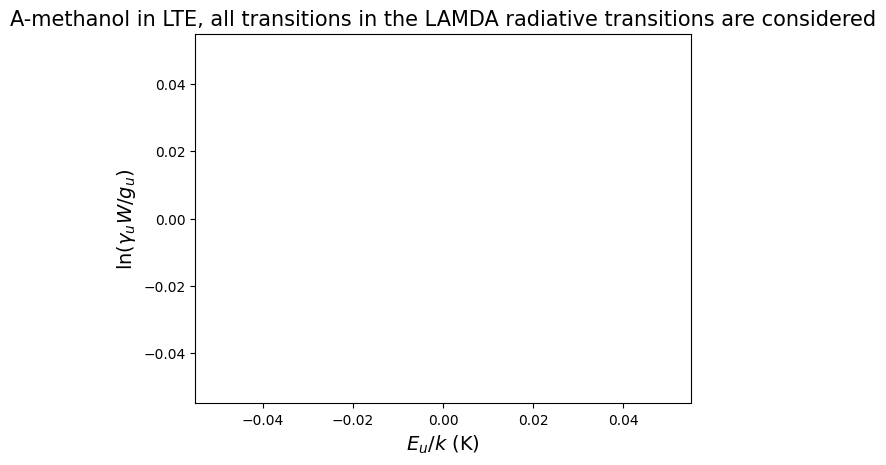

In [ ]:
# Take only N first transitions
# firstN_transitions = 800

# calculate get y values using column density of the upper level
y_values_metanol_k0 = np.log(data_k0["Nu"] / data_k0["gu"])

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(data_k0["Eu"], y_values_metanol_k0, marker="x", color="red", label="K = 0")

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("A-methanol in LTE, all transitions in the LAMDA radiative transitions are considered", fontsize=15)

# Fit a straight line to estimate T_ex for K=0
fit_k0 = np.polyfit(data_k0["Eu"], y_values_metanol_k0, 1)  # Linear fit
T_ex_k0 = -1 / fit_k0[0]  # Rotational temperature from slope

# Calculate the fitted y-values for K=0
x_fit_k0 = np.linspace(min(data_k0["Eu"]), max(data_k0["Eu"]), 100)
y_fit_k0 = fit_k0[0] * x_fit_k0 + fit_k0[1]

# Calculate chi-squared for K=0
y_fit_observed_k0 = fit_k0[0] * data_k0["Eu"] + fit_k0[1]
chi_squared_k0 = np.sum(((y_values_metanol_k0 - y_fit_observed_k0) ** 2) / y_fit_observed_k0)

# reduced chi_squared: chi_squared / (num_point - num_parameters), num_parameters = 1 for a straight line
chi_squared_red_k0 = chi_squared_k0 / (len(data_k0["Eu"]) - 2)

# Plot the best-fit line for K=0
plt.plot(
    x_fit_k0,
    y_fit_k0,
    linestyle="-",
    color="black",
    label=(f"Fit K=0: $T_{{ex}}$ = {T_ex_k0:.5g} K\n$\chi^2_{{red}}$ = {chi_squared_red_k0:.5g}"),
)

plt.legend()
ax.grid()
plt.show()
